## **F1L Notebook 2 of 3: UMAP exploration**
This notebook follows the second part (2 of 3) of the FigureOne Lab Internship Emulator developed by Dean Lee. The code is modified from [Dean's repo](https://github.com/deanslee/FigureOneLab/tree/main/kinker). In this script, I try to renact Fig2B and 2D using Pan-cancer cell line heterogeneity single-cell RNA-seq dataset (Kinker et al, 2020). This notebook demonstrates the utility of scanpy to explore discrete and continuous patterns among cancer cell lines.

### 1. Set up python

In [1]:
# install additional packages
! pip install --quiet anndata scanpy igraph leidenalg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.9 MB/s eta 0:00:00


In [21]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import re
from itertools import product
pd.options.display.max_rows = 4000

# set up warning for cleaner code
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

from google.colab import drive
drive.mount('/content/drive')

# save for future code reproducibility
!pip freeze > requirements_scanpy.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Load data

In [3]:
# upload previously processed data
adata = sc.read_h5ad('/content/drive/MyDrive/Datascience/kinker_etal_processed_data/240702_kinker_anndata_umap.h5ad')
adata

AnnData object with n_obs × n_vars = 53513 × 23081
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

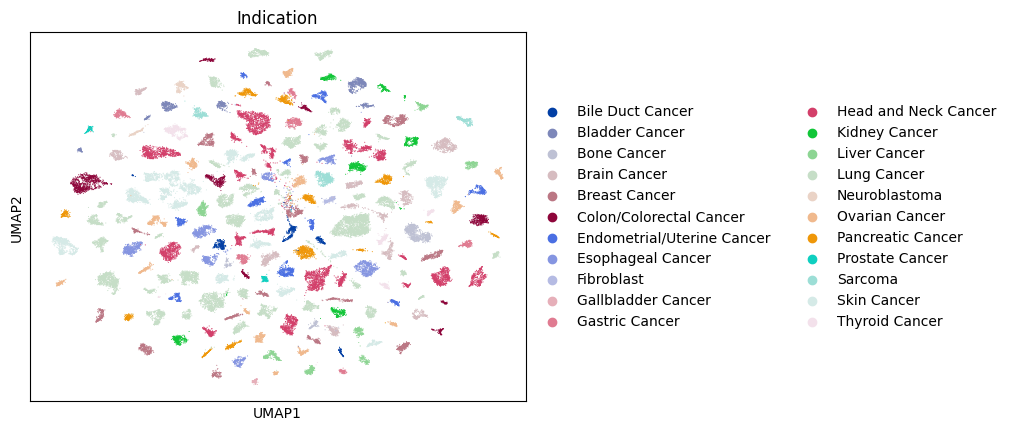

In [4]:
# example umap color coded by Indication (i.e. cancer cell type)
sc.pl.umap(adata, color=['Indication'])

Compared to Figure 1B (see below Kinker etal 2020) where cell clusters were displayed by cancer cell lines, in this UMAP diagram, we rather observed many small clusters for each cancer cell line.

The question is if this is an artifact or it is just a pattern detected by UMAP in the setting that was set. Let's try to color code this UMAP with different metadata such as pool, cell lines, and some highly mentioned RHPs.

1. No apparent clusters by pool - No pool technical artifact.
2. Each cluster seems to have subpopulation of cells at least by cell cycle, EpiSen, EMITIII, and potentially by other unplotted RHPs.

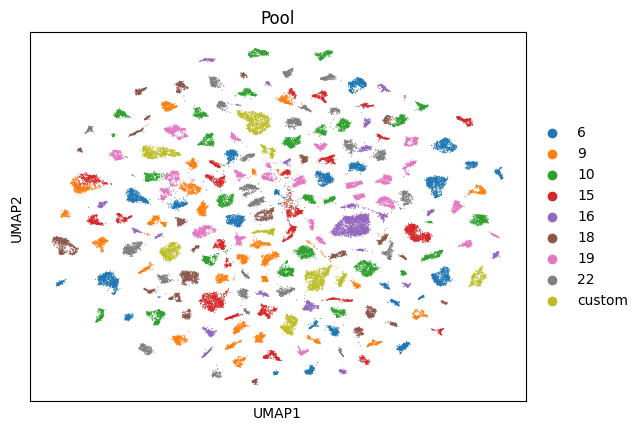

In [12]:
sc.pl.umap(adata, color=['Pool'])
# sc.pl.umap(adata, color=['CellLine']) # Too many cell lines

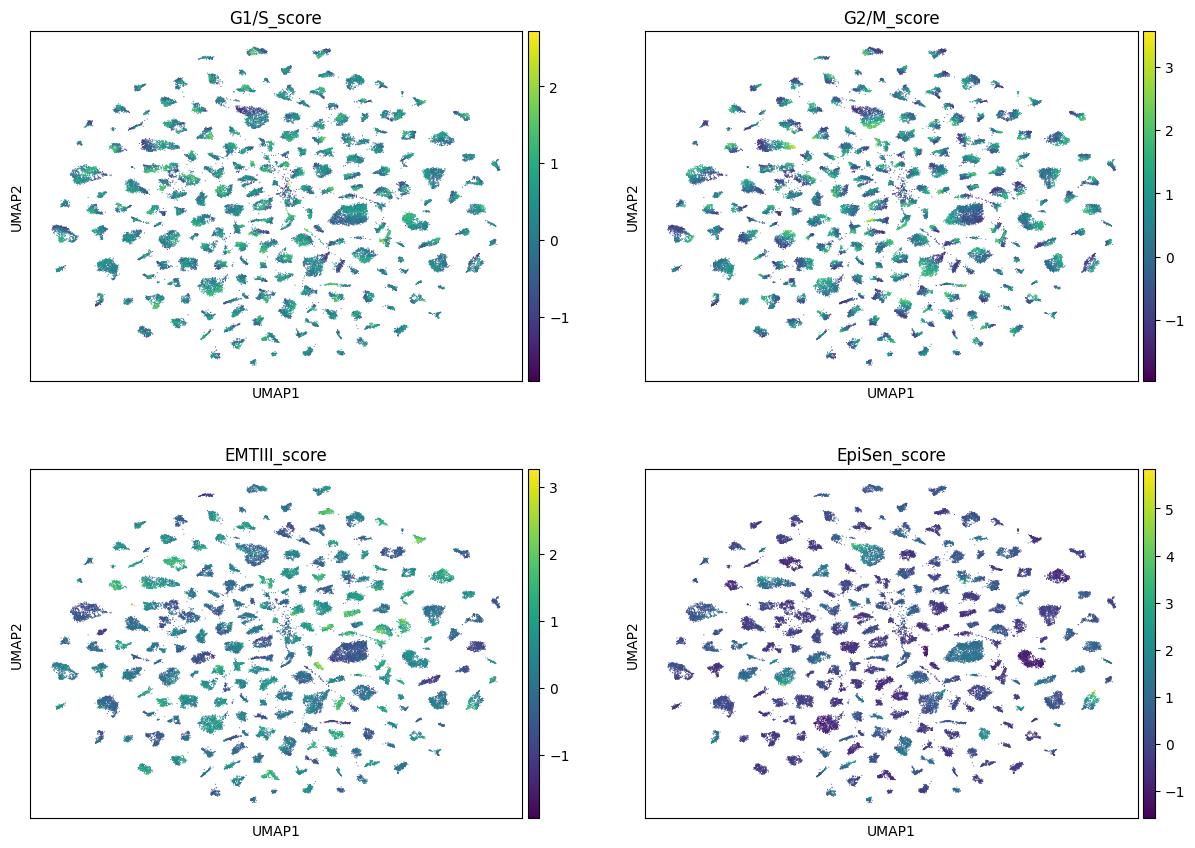

In [13]:
sc.pl.umap(adata, color=['G1/S_score', 'G2/M_score', 'EMTIII_score', 'EpiSen_score'], ncols=2)

### 3. Discrete and Continuous Patterns
Again, plotting UMAP by examples of RHPs show that RHPs are present across various cancer cell types. To investigate this a bit further, I will try to display similar plots to Figure 2B and 2D. These figures are trying to demonstrate that there exists discrete and continuous patterns of expression heterogeneity within cell lines.

In an attempt to replicate Figure 2B, UMAP parameters will be optimized to display data more clearly. I'll focus on three examples: NCIH2110, NCIH1299, and JHU006 (Figure 2B shows patterns among NCIH2110, NCIH1299, CAK12, and JHU006).

* 3.1 Determine the actual cell line names that appear in adata AnnData object.

In [14]:
# Grep cell line names in this list
cell_lines_names = ['NCIH2110', 'NCIH1299', 'JHU006']
unique_cell_lines = sc.get.obs_df(adata, keys=['CellLine'])['CellLine'].unique()

matched_names = []
for name in cell_lines_names:
    match = [cell_line for cell_line in unique_cell_lines if re.search(name, cell_line)]
    if match:
        matched_names.extend(match)  # Extend if multiple matches found
    else:
        matched_names.append('')

print(matched_names)

['NCIH2110_LUNG', 'NCIH1299_LUNG', 'JHU006_UPPER_AERODIGESTIVE_TRACT']


* 3.2 Create a function that optimizes UMAP parameters

UMAP layout can be modified to make cells located in more tight or dispersed structures. This can be regulated with the sc.tl.umap parameters min_dist and spread. Below we show UMAP exaples computed with different parameter combinations.
Ref https://scanpy-tutorials.readthedocs.io/en/latest/plotting/advanced.html

In [15]:
def umap_optimizer(adata_input, label_list):
    # Copy adata not to modify UMAP in the original adata object
    adata_temp = adata_input.copy()

    # Loop through different umap parameters, recomputting and replotting UMAP for each of them
    MIN_DISTS = [0.1, 1, 2]
    SPREADS = [0.5, 1, 5]

    # Create grid of plots, with a little extra room for the legends
    fig, axes = plt.subplots(
        len(MIN_DISTS), len(SPREADS), figsize=(len(SPREADS) * 3 + 2, len(MIN_DISTS) * 3)
    )

    for (i, min_dist), (j, spread) in product(enumerate(MIN_DISTS), enumerate(SPREADS)):
        ax = axes[i][j]
        param_str = " ".join(["min_dist =", str(min_dist), "and spread =", str(spread)])
        # Recompute UMAP with new parameters
        sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
        # Create plot, placing it in grid
        sc.pl.umap(
            adata_temp,
            color=label_list,
            title=param_str,
            s=40,
            ax=ax,
            show=False,
        )
    plt.tight_layout()
    plt.show()
    plt.close()
    del adata_temp

UMAP for NCIH2110

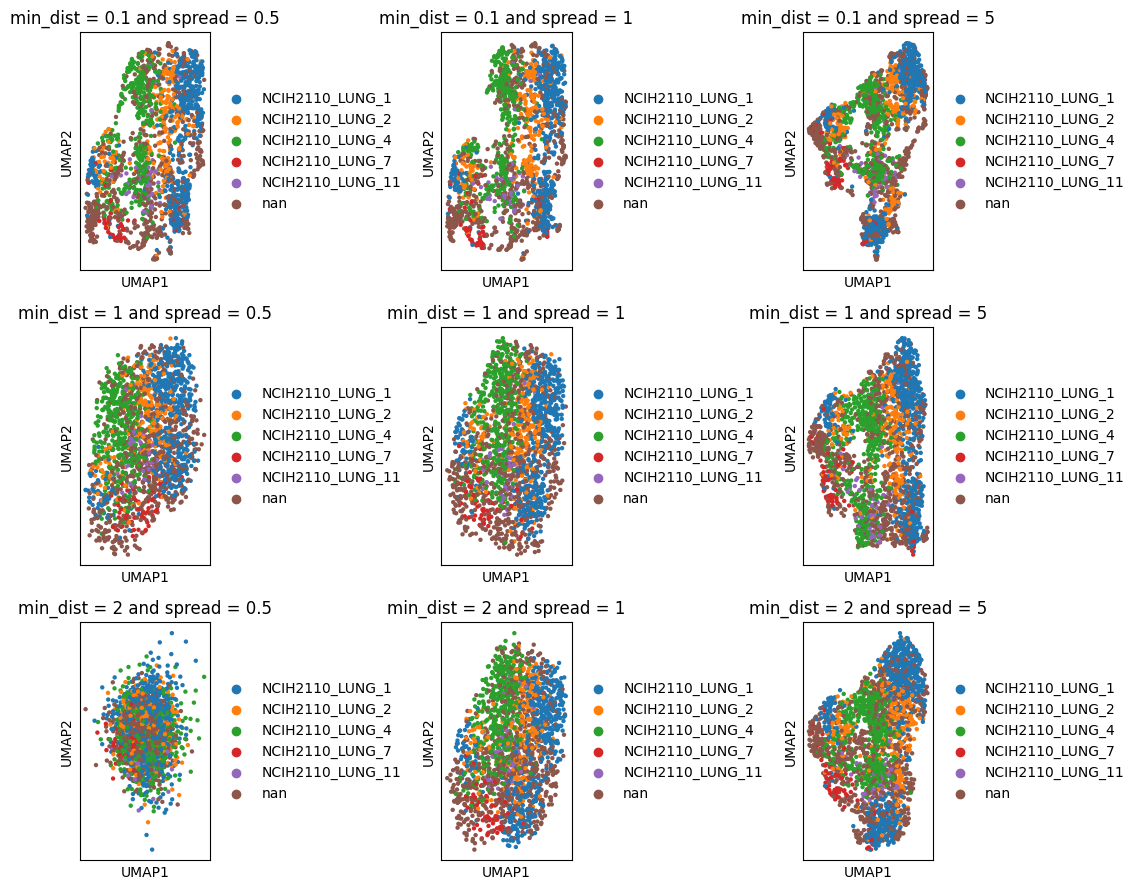

In [16]:
adata_NCIH2110 = adata[adata.obs['CellLine'] == 'NCIH2110_LUNG']
umap_optimizer(adata_NCIH2110, ['Discrete_cluster_minpts5_eps1.2'])

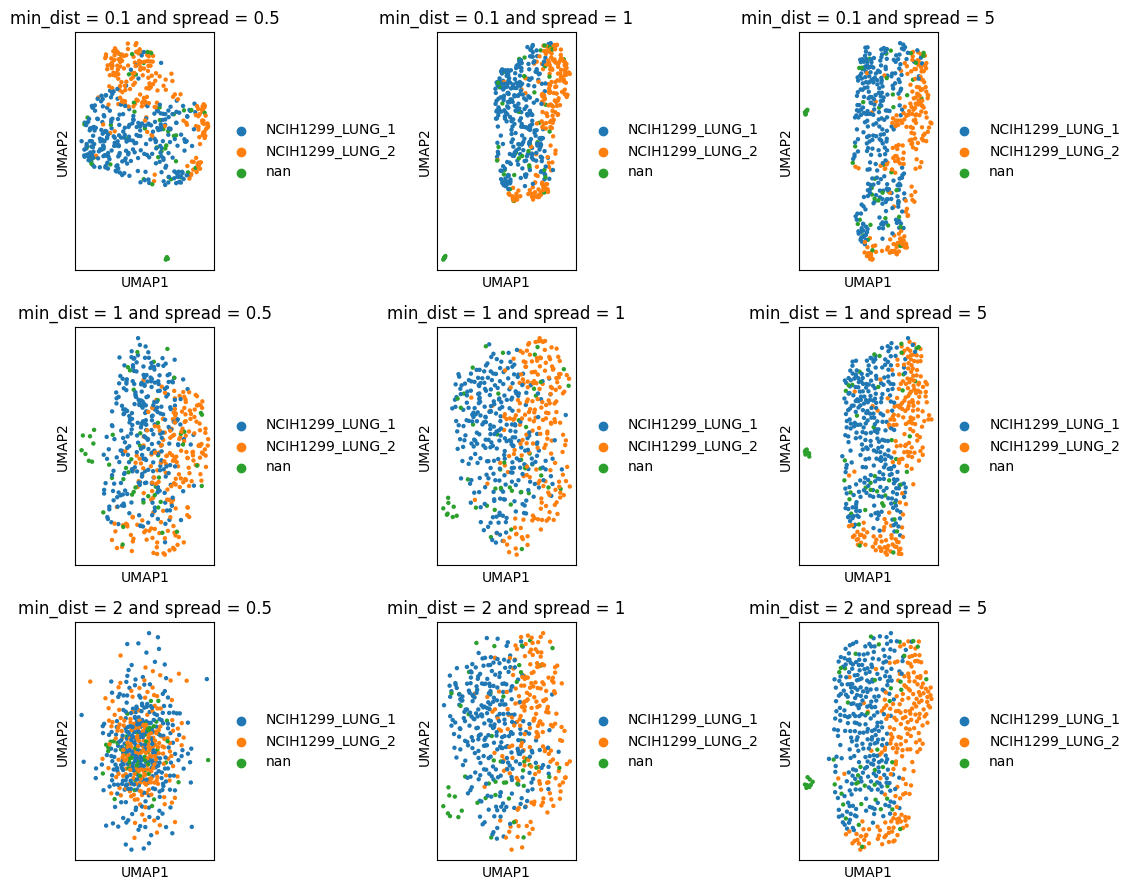

In [17]:
adata_NCIH1299 = adata[adata.obs['CellLine'] == 'NCIH1299_LUNG']
umap_optimizer(adata_NCIH1299, ['Discrete_cluster_minpts5_eps1.2'])

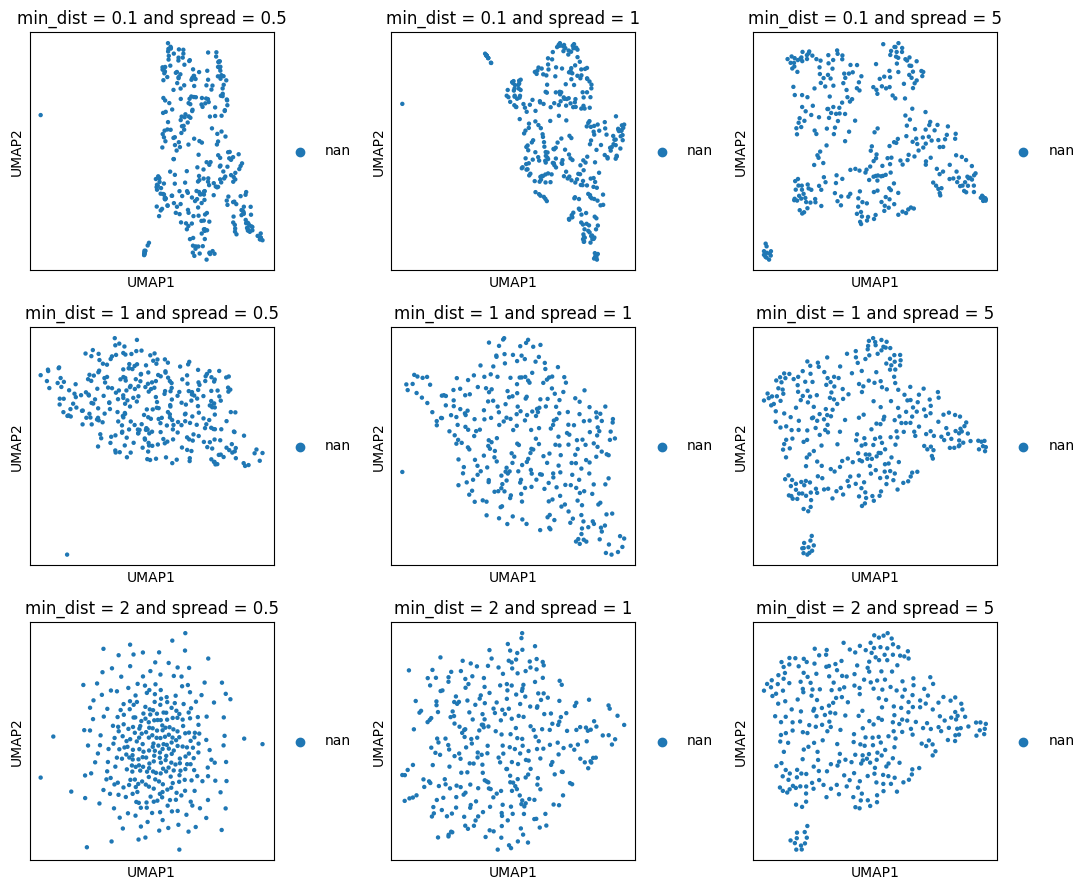

In [18]:
adata_JHU006 = adata[adata.obs['CellLine'] == 'JHU006_UPPER_AERODIGESTIVE_TRACT']
umap_optimizer(adata_JHU006, ['Discrete_cluster_minpts5_eps1.2'])

### 4.  RHPs in JHU006 Laryngeal Squamous Cell Carcinoma

Another part of this exercise is to plot a heatmap of top genes that define G1/S, G2/M, EMTs, and EpiSen RHPs.

In [35]:
# Obtain a list of genes defining RHPs
RHP_top_genes = pd.read_excel('/content/drive/MyDrive/Datascience/kinker_etal_processed_data/NIHMS1697424-supplement-Table_S4.xlsx')
print(RHP_top_genes.info())

rhp_genes = {
    'Cell Cycle - G1/S': RHP_top_genes['Cell Cycle - G1/S'].dropna().tolist(),
    'Cell Cycle - G2/M': RHP_top_genes['Cell Cycle - G2/M'].dropna().tolist(),
    'EMT I': RHP_top_genes['EMT I'].dropna().tolist(),
    'EMT II': RHP_top_genes['EMT II'].dropna().tolist(),
    'EMT III': RHP_top_genes['EMT III'].dropna().tolist(),
    'Epithelial Senescence': RHP_top_genes['Epithelial Senescence'].dropna().tolist()
}
rhp_genes_df = pd.DataFrame(
    [(key, gene) for key, genes in rhp_genes.items() for gene in genes],
    columns=['RHP', 'gene'])

# Print genes in each RHP
grouped_genes = rhp_genes_df.groupby('RHP')['gene'].apply(list).to_dict()
for key, val in grouped_genes.items():
    print(f"* {key}: {', '.join(val)}")

# Create list of all genes in RHPs for filtering adata
all_genes_of_interest = rhp_genes_df['gene'].tolist()
# print(all_genes_of_interest)
# print(len(all_genes_of_interest))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Cell Cycle - G1/S          46 non-null     object
 1   Cell Cycle - G2/M          62 non-null     object
 2   Skin Pigmentation          47 non-null     object
 3   EMT I                      79 non-null     object
 4   EMT II                     28 non-null     object
 5   IFN Response               49 non-null     object
 6   EMT III                    49 non-null     object
 7   p53-Dependent Senescence   19 non-null     object
 8   Epithelial Senescence      38 non-null     object
 9   Stress Response            36 non-null     object
 10  Protein Maturation         34 non-null     object
 11  Proteasomal Degradation    46 non-null     object
dtypes: object(12)
memory usage: 7.5+ KB
None
* Cell Cycle - G1/S: HIST1H4C, CLSPN, ATAD2, E2F1, HELLS, RRM2, HIST2H2AC, HIST1H

In [25]:
# JHU006 Laryngeal Squamous Cell Carcinoma

# Filter for genes of interest
adata_JHU006_filtered = adata_JHU006[:, adata_JHU006.var_names.isin(all_genes_of_interest)]

# Add RHP category to genes to adata.var
gene_category_mapping = rhp_genes_df.set_index('gene')['RHP'].to_dict()

adata_JHU006_filtered.var['RHP'] = adata_JHU006_filtered.var_names.map(gene_category_mapping)

In [101]:
JHU006_expression_df = pd.DataFrame.sparse.from_spmatrix(
    adata_JHU006_filtered.X,
    index=adata_JHU006_filtered.obs_names,  # Cell names (rows)
    columns=adata_JHU006_filtered.var_names  # Gene names (columns)
    ).transpose().reset_index(names='gene')

# Need drop rows with all 0's because it messes up clustering and zscore cal
rows_with_all_zeros = (JHU006_expression_df.iloc[:, 1:326] == 0).all(axis=1)
JHU006_expression_df = JHU006_expression_df[~rows_with_all_zeros]
print(JHU006_expression_df.shape)

JHU006_expression_df['RHP'] = JHU006_expression_df['gene'].replace(gene_category_mapping)
JHU006_expression_df.sort_values(by=['RHP','gene'], inplace=True)

# Create a categorical color map for gene categories
categories = JHU006_expression_df['RHP'].drop_duplicates().sort_values()
category_colors = sns.color_palette("hls", len(categories))

JHU006_expression_df['RHPs'] = JHU006_expression_df['RHP'].map(dict(zip(categories, category_colors)))
JHU006_expression_df.index = JHU006_expression_df['gene']

# JHU006_expression_df.head()
# Convert SparseArray column dtype to numpy
JHU006_expression_df.iloc[:, 1:326] = JHU006_expression_df.iloc[:, 1:326].sparse.to_dense().astype(np.float64)

# No missing value
# JHU006_expression_df.iloc[:,1:326].isna().sum(axis=0).sum()

(272, 326)


<ipython-input-101-391f8734f70d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JHU006_expression_df['RHP'] = JHU006_expression_df['gene'].replace(gene_category_mapping)
<ipython-input-101-391f8734f70d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JHU006_expression_df.sort_values(by=['RHP','gene'], inplace=True)
<ipython-input-101-391f8734f70d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [102]:
import matplotlib.colors as mcolors

# Define the colors
colors = ["#67a9cf", "white", "red"]

# Create a colormap using LinearSegmentedColormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

'''
# Adjust the colormap to make it non-linear
# This example uses a power-law transformation, but you can experiment
# with other functions like log or exponential to fine-tune the transition.
def custom_cmap_function(x):
    return x**1  # Adjust the exponent to control the non-linearity

cmap = cmap(np.linspace(0, 1, 256))  # Generate 256 color values
cmap = mcolors.ListedColormap(cmap)  # Convert to ListedColormap

# Apply the non-linear transformation
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap_nonlinear", cmap(custom_cmap_function(np.linspace(0, 1, 256)))
)
'''

'\n# Adjust the colormap to make it non-linear\n# This example uses a power-law transformation, but you can experiment\n# with other functions like log or exponential to fine-tune the transition.\ndef custom_cmap_function(x):\n    return x**1  # Adjust the exponent to control the non-linearity\n\ncmap = cmap(np.linspace(0, 1, 256))  # Generate 256 color values\ncmap = mcolors.ListedColormap(cmap)  # Convert to ListedColormap\n\n# Apply the non-linear transformation\ncmap = mcolors.LinearSegmentedColormap.from_list(\n    "custom_cmap_nonlinear", cmap(custom_cmap_function(np.linspace(0, 1, 256)))\n)\n'

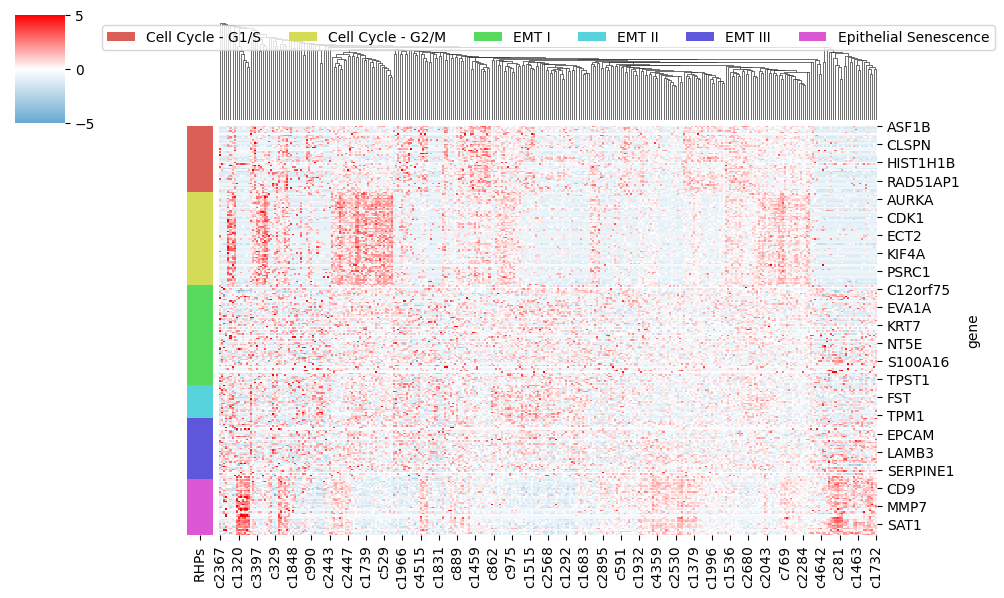

In [105]:
# Plot the heatmap
g = sns.clustermap(
    JHU006_expression_df.iloc[:,1:326],
    z_score=0, # calculate z-score for rows
    row_cluster=False,  # Do not cluster rows (genes)
    col_cluster=True,   # Cluster columns (cells)
    row_colors=JHU006_expression_df['RHPs'],  # Add gene category color labels
    cmap=cmap,     # Heatmap color map
    figsize=(10, 6),
    vmin=-5,          # Set minimum value for colormap
    vmax=5
)

# Customize the color legend
for label, color in zip(categories, category_colors):
    g.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="upper center", ncol=6)

# g.ax_heatmap.set_yticklabels(JHU006_expression_df['gene'])

plt.show()